In [1]:
import xarray as xr
import xmitgcm
import sandbox as sb

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tm4 = [-sb.degMinSec2decimal(70,54.0876), 
       sb.degMinSec2decimal(39,50.8542)]
at  = [-sb.degMinSec2decimal(70,53.1670), 
       sb.degMinSec2decimal(39,57.1500)]
line= sb.gcspace(tm4, at, npts=50)
print(line)

[[-70.90146, -70.9011595997056, -70.90085918147484, -70.90055874530536, -70.9002582911948, -70.8999578191408, -70.89965732914094, -70.89935682119288, -70.89905629529426, -70.89875575144266, -70.89845518963575, -70.89815460987114, -70.89785401214644, -70.8975533964593, -70.89725276280733, -70.89695211118816, -70.8966514415994, -70.8963507540387, -70.89605004850367, -70.89574932499191, -70.89544858350108, -70.89514782402877, -70.89484704657262, -70.89454625113025, -70.89424543769927, -70.89394460627732, -70.89364375686199, -70.89334288945092, -70.89304200404173, -70.89274110063204, -70.89244017921946, -70.89213923980161, -70.89183828237611, -70.89153730694058, -70.89123631349263, -70.89093530202987, -70.89063427254993, -70.89033322505043, -70.89003215952897, -70.88973107598318, -70.88942997441066, -70.88912885480903, -70.88882771717591, -70.88852656150891, -70.88822538780563, -70.88792419606371, -70.88762298628075, -70.88732175845435, -70.88702051258213, -70.8867192486617, -70.8864179666

In [3]:
data_dir = '/home/ivana/tutorial_global_oce_latlon/run'
grid_dir = data_dir

In [4]:
ds = xmitgcm.open_mdsdataset(data_dir, 
                             prefix=['ssp', 'T'], 
                             iters=[20])
ds = ds.squeeze()
ds = ds.isel(Z=0)

# PyInterp type interpolation

In [5]:
import numpy as np
import pyinterp
mesh = pyinterp.RTree()

In [6]:
#python nuissances to make the interp work
xc=[]; yc=[]
for i in range(90):
    if i < 40:
        xc.append(ds.XC.values.tolist())
    yc.append(ds.YC.values.tolist())
xc = np.array( xc )
yc = np.array( yc ).T
ssp= np.array( ds.ihop_ssp.values.tolist())

In [7]:
mesh.packing( np.vstack( (xc.ravel(), yc.ravel()) ).T,
             ssp.ravel() )

In [8]:
idw_ssp, idw_neighbors = mesh.inverse_distance_weighting(
    np.vstack((line[1],line[0])).T, 
    within = True,
    #radius = 100000, #100 km radius
    k=101
)

In [9]:
rbf_ssp, rbf_neighbors = mesh.radial_basis_function(
    np.vstack((line[1],line[0])).T,
    radius=1000000,
    within=True,  # Extrapolation is forbidden
    k=11  # We are looking for at most 11 neighbours
)

In [10]:
rbf_neighbors

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11], dtype=uint32)

# Visualize pyinterp results

In [11]:
import cartopy.crs
import cartopy.mpl.ticker

In [12]:
xc , yc = np.meshgrid(ds.XC, ds.YC)

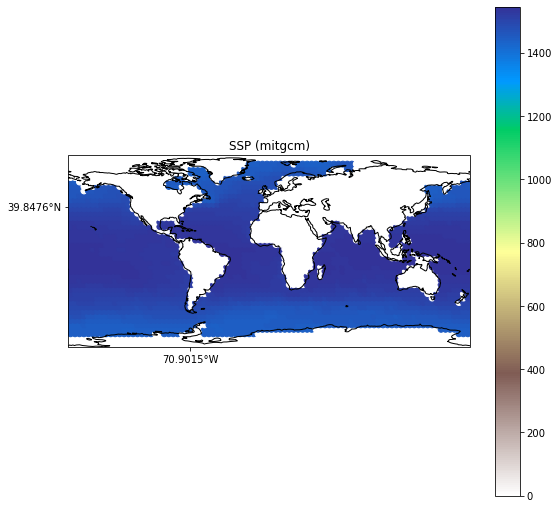

In [13]:
fig = plt.figure(figsize=(9, 9))
lon_formatter = cartopy.mpl.ticker.LongitudeFormatter(
    zero_direction_label=True)
lat_formatter = cartopy.mpl.ticker.LatitudeFormatter()

ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
im=ax.scatter(   xc,
              yc,
              c=ds.ihop_ssp,
              cmap='terrain_r',
              s=35,
              transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(line[0][0], line[0][-1], 10.0))
ax.set_yticks(np.arange(line[1][0], line[1][-1], 10.0))
ax.set_title('SSP (mitgcm)')

#im.set_clim(min(rbf_ssp), max(idw_ssp))
plt.colorbar(im)

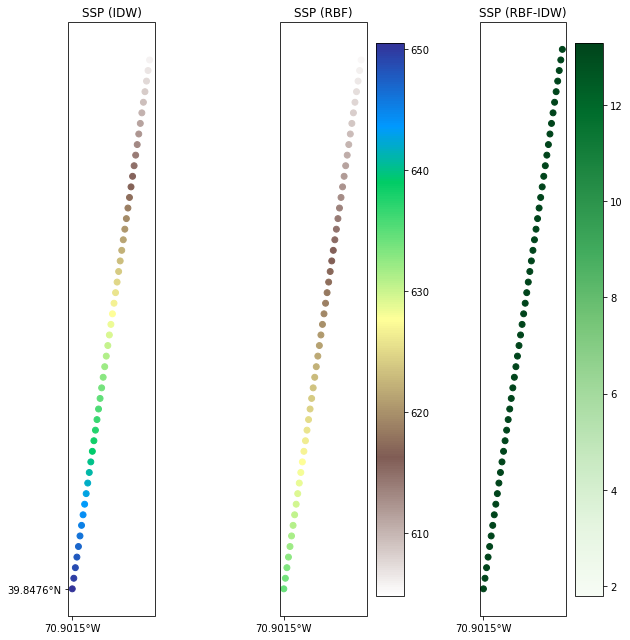

In [14]:
fig = plt.figure(figsize=(9, 9))
lon_formatter = cartopy.mpl.ticker.LongitudeFormatter(
    zero_direction_label=True)
lat_formatter = cartopy.mpl.ticker.LatitudeFormatter()

ax = fig.add_subplot(131, projection=cartopy.crs.PlateCarree())
ax.scatter(   line[0],
              line[1],
              c=idw_ssp,
              cmap='terrain_r',
              s=35,
              transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(line[0][0], line[0][-1], 10.0))
ax.set_yticks(np.arange(line[1][0], line[1][-1], 10.0))
ax.set_title('SSP (IDW)')

ax = fig.add_subplot(132, projection=cartopy.crs.PlateCarree())
im = ax.scatter(   line[0],
              line[1],
              c=rbf_ssp,
              cmap='terrain_r',
              s=35,
              transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(line[0][0], line[0][-1], 10.0))
ax.set_title('SSP (RBF)')
im.set_clim(min(rbf_ssp), max(idw_ssp))
plt.colorbar(im)

ax = fig.add_subplot(133, projection=cartopy.crs.PlateCarree())
im = ax.scatter(   line[0],
              line[1],
              c=np.abs(rbf_ssp-idw_ssp),
              cmap='Greens',
              s=35,
              transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(line[0][0], line[0][-1], 10.0))
ax.set_title('SSP (RBF-IDW)')
im.set_clim(min(rbf_ssp), max(idw_ssp))
im.set_clim(1.8, 13.3)
plt.colorbar(im)

fig.tight_layout()
fig.show()

values of interp aren't even close to the values of ssp in the ocean. Off by an order of magnitude!